In [13]:
import glob

import matplotlib.pyplot as plt
import xarray as xr

from unseen import fileio
from unseen import time_utils

In [3]:
agcd_files = glob.glob('/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_*_daily.nc')
agcd_files.sort()

### Entire East Coast (EC) flood zone

In [12]:
ec_ds_list = []
for infile in agcd_files:
    print(infile)
    ds = fileio.open_dataset(
        infile,
        metadata_file='/home/599/dbi599/forks/unseen/config/dataset_agcd_daily.yml',
        shapefile='/g/data/xv83/dbi599/east-coast-rain/shapefiles/east-coast-flood.shp',
        variables=['pr'],
        spatial_agg='mean', 
    )
    ds = ds.compute()
    ec_ds_list.append(ds)

/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_19000101-19001231_daily.nc
/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_19010101-19011231_daily.nc
/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_19020101-19021231_daily.nc
/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_19030101-19031231_daily.nc
/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_19040101-19041231_daily.nc
/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_19050101-19051231_daily.nc
/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_19060101-19061231_daily.nc
/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_19070101-19071231_daily.nc
/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_19080101-19081231_daily.nc
/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_19090101-19091231_daily.nc
/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_19100101-19101231_daily.nc
/g/data/xv83/agcd-csiro/precip/precip-total

/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_19950101-19951231_daily.nc
/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_19960101-19961231_daily.nc
/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_19970101-19971231_daily.nc
/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_19980101-19981231_daily.nc
/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_19990101-19991231_daily.nc
/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_20000101-20001231_daily.nc
/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_20010101-20011231_daily.nc
/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_20020101-20021231_daily.nc
/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_20030101-20031231_daily.nc
/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_20040101-20041231_daily.nc
/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_20050101-20051231_daily.nc
/g/data/xv83/agcd-csiro/precip/precip-total

In [15]:
ec_ds = xr.concat(ec_ds_list, dim='time')

In [16]:
ec_ds

<xarray.Dataset>
Dimensions:  (time: 44641)
Coordinates:
  * time     (time) object 1900-01-01 09:00:00 ... 2022-03-22 09:00:00
Data variables:
    pr       (time) float32 2.617 0.2759 0.1095 0.3672 ... 3.118 0.1763 0.01809
Attributes: (12/33)
    CDI:                           Climate Data Interface version ?? (http://...
    history:                       Tue Sep 03 14:23:23 2019: cdo -O -z zip_4 ...
    institution:                   Australian Bureau of Meteorology, GPO Box ...
    Conventions:                   CF-1.6
    geospatial_lat_min:            -44.525
    geospatial_lat_max:            -9.975
    ...                            ...
    url:                           http://www.bom.gov.au/climate/
    licence:                       Copyright for any data supplied by the Bur...
    id:                            Australian Gridded Climate Data (AGCD)
    summary:                       The daily and monthly rainfall data repres...
    naming_authority:              au.gov.bom
    CDO:                           Climate Data Operators version 1.7.0 (http...

In [17]:
ec_ds = ec_ds.compute()

In [18]:
ec_ds_15day = ec_ds.rolling({'time': 15}).sum()

In [19]:
ec_ds_rx15day = time_utils.temporal_aggregation(ec_ds_15day, 'A-AUG', 'D', 'max', ['pr'])

In [20]:
ec_ds_rx15day['pr']

<xarray.DataArray 'pr' (time: 123)>
array([157.16131592, 154.21635437, 108.1078949 , 113.44795227,
       143.36843872, 163.22416687, 115.16177368, 145.8506012 ,
       181.83099365,  84.90094757, 152.50154114, 198.05415344,
       105.62220764, 147.20663452, 158.33149719, 132.58703613,
       148.13774109, 146.88981628, 169.06446838, 154.64064026,
       148.61068726, 158.72315979, 221.8807373 ,  88.81480408,
        97.46022797, 131.76338196, 131.31005859, 202.08508301,
       254.96972656, 275.87484741, 150.64588928, 176.09979248,
       135.76211548, 151.24320984, 148.18060303, 107.03565216,
        98.37158966, 197.09915161, 181.85357666, 211.05673218,
        75.45166779, 120.78094482, 117.3535614 , 150.98733521,
       128.78395081, 197.03915405, 189.28764343, 160.98873901,
       177.32992554, 142.28945923, 247.46858215, 224.8742218 ,
       155.95506287, 184.94955444, 279.74612427, 175.49874878,
       264.99197388, 103.43411255, 128.18354797, 147.07730103,
       151.7802124 , 142.94129944, 180.66001892, 267.0144043 ,
       124.96346283, 132.44689941, 130.96420288, 215.42163086,
       269.90011597, 111.1295929 , 118.17034912, 240.57929993,
       180.55622864, 204.81008911, 206.86535645, 146.06782532,
       211.89562988, 244.55987549, 249.76698303, 110.43641663,
       184.51371765, 152.35519409, 144.04882812, 164.54655457,
       126.72047424, 148.11416626, 126.18432617, 124.39672852,
       287.58004761, 245.78253174, 224.3331604 , 144.14038086,
       177.9540863 , 103.61034393, 118.66257477, 150.98930359,
       235.38262939, 118.13663483, 107.40421295, 176.82089233,
       121.8742981 , 207.00506592, 124.1680603 , 155.49478149,
       150.4022522 , 136.14094543, 135.45600891, 134.99803162,
       168.65151978, 170.87754822, 147.48348999, 182.67929077,
       202.14846802, 287.37878418, 150.58462524, 162.28218079,
       151.03944397, 212.79969788, 132.92233276, 124.44194794,
       288.79724121, 287.60452271, 410.44726562])
Coordinates:
  * time     (time) object 1900-08-31 00:00:00 ... 2022-08-31 00:00:00
Attributes:
    standard_name:                 lwe_thickness_of_precipitation_amount
    long_name:                     Daily precipitation
    units:                         mm day-1
    cell_methods:                  time: sum
    analysis_version_number:       3.01
    number_of_stations_reporting:  2757
    source:                        Interpolated surface observations
    frequency:                     daily
    length_scale_for_analysis:     80.0
    analysis_time:                 2010-10-23 14:49:46 UTC

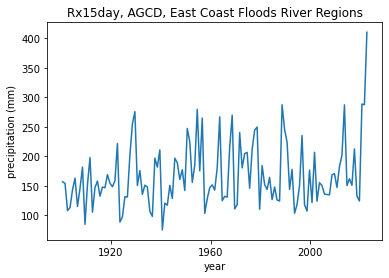

In [29]:
ec_ds_rx15day['pr'].plot()
plt.title('Rx15day, AGCD, East Coast Floods River Regions')
plt.ylabel('precipitation (mm)')
plt.xlabel('year')
plt.show()

## NSW coast

In [23]:
sec_ds_list = []
for infile in agcd_files:
    print(infile)
    ds = fileio.open_dataset(
        infile,
        metadata_file='/home/599/dbi599/forks/unseen/config/dataset_agcd_daily.yml',
        shapefile='/g/data/xv83/dbi599/east-coast-rain/shapefiles/south-east-coast-nsw.shp',
        variables=['pr'],
        spatial_agg='mean', 
    )
    ds = ds.compute()
    sec_ds_list.append(ds)

/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_19000101-19001231_daily.nc
/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_19010101-19011231_daily.nc
/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_19020101-19021231_daily.nc
/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_19030101-19031231_daily.nc
/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_19040101-19041231_daily.nc
/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_19050101-19051231_daily.nc
/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_19060101-19061231_daily.nc
/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_19070101-19071231_daily.nc
/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_19080101-19081231_daily.nc
/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_19090101-19091231_daily.nc
/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_19100101-19101231_daily.nc
/g/data/xv83/agcd-csiro/precip/precip-total

/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_19950101-19951231_daily.nc
/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_19960101-19961231_daily.nc
/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_19970101-19971231_daily.nc
/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_19980101-19981231_daily.nc
/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_19990101-19991231_daily.nc
/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_20000101-20001231_daily.nc
/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_20010101-20011231_daily.nc
/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_20020101-20021231_daily.nc
/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_20030101-20031231_daily.nc
/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_20040101-20041231_daily.nc
/g/data/xv83/agcd-csiro/precip/precip-total_AGCD-CSIRO_r005_20050101-20051231_daily.nc
/g/data/xv83/agcd-csiro/precip/precip-total

In [24]:
sec_ds = xr.concat(sec_ds_list, dim='time')

In [25]:
sec_ds = sec_ds.compute()

In [26]:
sec_ds_15day = sec_ds.rolling({'time': 15}).sum()

In [27]:
sec_ds_rx15day = time_utils.temporal_aggregation(sec_ds_15day, 'A-AUG', 'D', 'max', ['pr'])

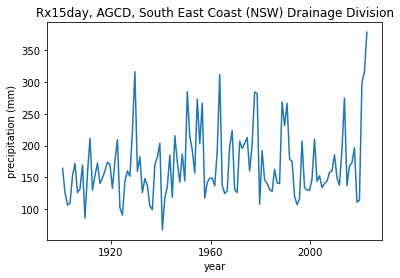

In [28]:
sec_ds_rx15day['pr'].plot()
plt.title('Rx15day, AGCD, South East Coast (NSW) Drainage Division')
plt.ylabel('precipitation (mm)')
plt.xlabel('year')
plt.show()